In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

In [2]:
torch.__version__
torch.cuda.is_available()

True

## 0. Define neceassy structures

In [3]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, dims, non_linearity):
        """
        Args:
            dims: list of ints
            non_linearity: differentiable function

        Returns: nn.Module which represents an MLP with architecture

            x -> Linear(dims[0], dims[1]) -> non_linearity ->
            ...
            Linear(dims[-3], dims[-2]) -> non_linearity ->
            Linear(dims[-2], dims[-1]) -> y
            last layer is linear layer"""

        super(MultilayerPerceptron, self).__init__()
        self.dims = dims
        self.non_linearity = non_linearity
        self.linear_modules = nn.ModuleList()
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            self.linear_modules.append(nn.Linear(in_dim, out_dim))

    def forward(self, x):
        """
        Args:
            x: input data into this NN module, Tensor
        
        Returns: Feedforward Output
        """
        temp = x
        for linear_module in self.linear_modules[:-1]:
            temp = self.non_linearity(linear_module(temp))
        return self.linear_modules[-1](temp)
    
def init_mlp(in_dim, out_dim, hidden_dim, num_hid_layers=1, non_linearity=nn.ReLU()):
    """Initializes a MultilayerPerceptron.

    Args:
        in_dim: int, intput dimension
        out_dim: int, output dimension
        hidden_dim: int, hidden layer width
        num_hid_layers: int, hidden layer number
        non_linearity: differentiable function

    Returns: a MultilayerPerceptron with the architecture

        x -> Linear(in_dim, hidden_dim) -> non_linearity ->
        ...
        Linear(hidden_dim, hidden_dim) -> non_linearity ->
        Linear(hidden_dim, out_dim) -> y

        where num_layers = 0 corresponds to

        x -> Linear(in_dim, out_dim) -> y"""
    dims = [in_dim] + [hidden_dim for _ in range(num_hid_layers)] + [out_dim]
    return MultilayerPerceptron(dims, non_linearity)

In [4]:
def lognormexp(values, dim=0):
    """Exponentiates, normalizes and takes log of a tensor.

    Args:
        values: tensor [dim_1, ..., dim_N]
        dim: n

    Returns:
        result: tensor [dim_1, ..., dim_N]
            where result[i_1, ..., i_N] =
                                 exp(values[i_1, ..., i_N])
            log( ------------------------------------------------------------ )
                    sum_{j = 1}^{dim_n} exp(values[i_1, ..., j, ..., i_N])
    """

    log_denominator = torch.logsumexp(values, dim=dim, keepdim=True)
    # log_numerator = values
    return values - log_denominator

def exponentiate_and_normalize(values, dim=0):
    """Exponentiates and normalizes a tensor.

    Args:
        values: tensor [dim_1, ..., dim_N]
        dim: n

    Returns:
        result: tensor [dim_1, ..., dim_N]
            where result[i_1, ..., i_N] =
                            exp(values[i_1, ..., i_N])
            ------------------------------------------------------------
             sum_{j = 1}^{dim_n} exp(values[i_1, ..., j, ..., i_N])
    """

    return torch.exp(lognormexp(values, dim=dim))

def get_thermo_loss_from_log_weight_log_p_log_q(log_weight, log_p, log_q, partition, num_particles=1,
                                                integration='left'):
    """Args:
        log_weight: tensor of shape [batch_size, num_particles]
        log_p: tensor of shape [batch_size, num_particles]
        log_q: tensor of shape [batch_size, num_particles]
        partition: partition of [0, 1];
            tensor of shape [num_partitions + 1] where partition[0] is zero and
            partition[-1] is one;
            see https://en.wikipedia.org/wiki/Partition_of_an_interval
        num_particles: int
        integration: left, right or trapz

    Returns:
        loss: scalar that we call .backward() on and step the optimizer.
        elbo: average elbo over data
    """
    heated_log_weight = log_weight.unsqueeze(-1) * partition
    heated_normalized_weight = exponentiate_and_normalize(
        heated_log_weight, dim=1)
    thermo_logp = partition * log_p.unsqueeze(-1) + \
        (1 - partition) * log_q.unsqueeze(-1)

    wf = heated_normalized_weight * log_weight.unsqueeze(-1)
    w_detached = heated_normalized_weight.detach()
    wf_detached = wf.detach()
    if num_particles == 1:
        correction = 1
    else:
        correction = num_particles / (num_particles - 1)

    cov = correction * torch.sum(
        w_detached * (log_weight.unsqueeze(-1) - torch.sum(wf, dim=1, keepdim=True)).detach() *
        (thermo_logp - torch.sum(thermo_logp * w_detached, dim=1, keepdim=True)),
        dim=1)

    multiplier = torch.zeros_like(partition)
    if integration == 'trapz':
        multiplier[0] = 0.5 * (partition[1] - partition[0])
        multiplier[1:-1] = 0.5 * (partition[2:] - partition[0:-2])
        multiplier[-1] = 0.5 * (partition[-1] - partition[-2])
    elif integration == 'left':
        multiplier[:-1] = partition[1:] - partition[:-1]
    elif integration == 'right':
        multiplier[1:] = partition[1:] - partition[:-1]

    loss = -torch.mean(torch.sum(
        multiplier * (cov + torch.sum(
            w_detached * log_weight.unsqueeze(-1), dim=1)),
        dim=1))

    return loss

In [5]:
class VAE:
    def __init__(self, x_dim, z_dim, x_var, 
                encoder_hid_layer_num, encoder_hid_width,
                decoder_hid_layer_num, decoder_hid_width,
                encoder_nonlinearity = nn.ReLU(),
                decoder_nonlinearity = nn.ReLU()):
        """VAE framework constructor
        Args:
            x_dim: Dimension of observations, int
            z_dim: Dimension of latent space, int
            x_var: varaince of generative model
            en/decoder_hid_layer_num: hidden layer number of en/decoder net, int
            en/decoder_hid_width: dim of en/decoder hidden layer, int
            en/decoder_nonlinearity: torch differentiable function"""
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.x_var = x_var

        self.encoder = init_mlp(self.x_dim, self.z_dim*2, 
                                encoder_hid_width, encoder_hid_layer_num,
                                encoder_nonlinearity)
        self.decoder = init_mlp(self.z_dim, self.x_dim,
                                decoder_hid_width, decoder_hid_layer_num,
                                decoder_nonlinearity)
        self.encoder=self.encoder.cuda()
        self.decoder=self.decoder.cuda()
        self.objective_trace = []
    
    def generate(self, N=300):
        """On CPU, use the generative model to generate x given zs sampled from the prior
        Returns: Synthetic observation points Pytorch Tensor with shape (N, x_dim)"""
        z_samples = torch.normal(0, 1, size=(N,self.z_dim))
        decodercpu = self.decoder.cpu()
        return decodercpu.forward(z_samples)
    
    def infer(self, x):
        """Use the encoder to infer mean and sigma of q(z|x)
        Args:
            x: observation points, torch tensor, shape (N, x_dim)
        Returns: 
            mean: mean of q(z|x), torch tensor, shape (N, z_dim)
            std: std of q(z|x), positive, torch tensor, shape (N, z_dim)"""
        z_params = self.encoder.forward(x)
        mean = z_params[:,:self.z_dim]
        parameterized_std = z_params[:,self.z_dim:]
        std = torch.exp(parameterized_std) # To keep the std positive
        return mean, std
    
    def make_elbo_objective(self, x_train, S):
        '''Make ELBO objective function'''
        assert len(x_train.shape) == 2
        assert x_train.shape[1] == self.x_dim
        if S is not None:
            self.S = S
        N = x_train.shape[0] #sample numbers
        
        #infer zs with encoder 
        mean, std = self.infer(x_train)
        assert std.shape == (N, self.z_dim)
        assert mean.shape == (N, self.z_dim)
        
        #sample zs with the parameters
        z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)).cuda() * std + mean
        assert z_samples.shape == (self.S, N, self.z_dim)
        
        #predict xs
        x = self.decoder.forward(z_samples)
        assert x.shape == (self.S, N, self.x_dim)
        
        #evaluate log_likelihood p(y_n)
        norm1 = torch.distributions.Normal(x, self.x_var**0.5)
        log_likelihood = torch.sum(norm1.log_prob(x_train), axis=-1)
        assert log_likelihood.shape == (self.S, N)
        
        #evaluate sampled zs under prior 
        norm2 = torch.distributions.Normal(0.0, 1.0)
        log_pz = torch.sum(norm2.log_prob(z_samples), axis=-1)
        assert log_pz.shape == (self.S, N)
        
        #evaluate sampled z's under variational distribution
        norm3 = torch.distributions.Normal(mean, std)
        log_qz_given_x = torch.sum(norm3.log_prob(z_samples), axis=-1)
        
        elbo = torch.mean(log_likelihood - log_qz_given_x + log_pz)
        
        return -elbo
    
    def make_tvo_objective(self, x_train, S, partition, num_particles=10, integration='left'):
        '''Make TVO objective function'''
        assert len(x_train.shape) == 2
        assert x_train.shape[1] == self.x_dim
        if S is not None:
            self.S = S
        N = x_train.shape[0] #sample numbers
        
        #infer zs with encoder 
        mean, std = self.infer(x_train)
        assert std.shape == (N, self.z_dim)
        assert mean.shape == (N, self.z_dim)
        
        #sample zs with the parameters
        z_samples = torch.normal(0,1,size=(self.S, N, self.z_dim)).cuda() * std + mean
        assert z_samples.shape == (self.S, N, self.z_dim)
        
        #predict xs
        x = self.decoder.forward(z_samples)
        assert x.shape == (self.S, N, self.x_dim)
        
        #evaluate log_likelihood p(y_n)
        norm1 = torch.distributions.Normal(x, self.x_var**0.5)
        log_likelihood = torch.sum(norm1.log_prob(x_train), axis=-1)
        assert log_likelihood.shape == (self.S, N)
        
        #evaluate sampled zs under prior 
        norm2 = torch.distributions.Normal(0.0, 1.0)
        log_pz = torch.sum(norm2.log_prob(z_samples), axis=-1)
        assert log_pz.shape == (self.S, N)
        
        #evaluate sampled z's under variational distribution
        norm3 = torch.distributions.Normal(mean, std)
        log_qz_given_x = torch.sum(norm3.log_prob(z_samples), axis=-1)
        
        log_weight = log_likelihood - log_qz_given_x + log_pz
        log_p = log_likelihood
        log_q = log_qz_given_x - log_pz
        
        return get_thermo_loss_from_log_weight_log_p_log_q(log_weight, 
                                                           log_p, 
                                                           log_q, 
                                                           partition, 
                                                           num_particles,
                                                           integration)
    

In [6]:
from tqdm.notebook import tqdm

def train_ELBO_VAE_batched(x_train, 
                   x_var = 0.01,
                   z_dim = 2,
                   width = 50,
                   hidden_layers = 1, 
                   learning_rate = 0.01,
                   S = 10,
                   n_epochs = 5000, 
                   report_iter = 50, 
                   batch_size = 256):
    x_dim = x_train.shape[1]
    x_trainT = torch.tensor(x_train).float().cuda()
    batch_num = int(x_train.shape[0]/batch_size)
    vae_instance = VAE(x_dim, z_dim, x_var, hidden_layers, width, hidden_layers, width)
    parameters = list(vae_instance.encoder.parameters())+list(vae_instance.decoder.parameters())
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)
    counter=0
    for epoch in tqdm(range(n_epochs)):
        x_trainT=x_trainT[torch.randperm(x_trainT.size()[0])]
        for i in range(batch_num):
            x_batch = x_trainT[i*batch_size:(i+1)*batch_size,:]
            optimizer.zero_grad()
            loss = vae_instance.make_elbo_objective(x_trainT, S)
            loss.backward()
            optimizer.step()
            counter=counter+1
            if counter % report_iter == 0:
                vae_instance.objective_trace.append(loss.item())
    return vae_instance

def train_TVO_VAE_batched(x_train, 
                  x_var = 0.01,
                  z_dim = 2,
                  width = 50,
                  hidden_layers = 1, 
                  learning_rate = 0.01, 
                  partition = torch.tensor([0,0.25,0.5,0.75,1.]),
                  S = 10,
                  n_epochs = 5000, 
                  report_iter = 50, 
                  batch_size = 256):
    x_dim = x_train.shape[1]
    x_trainT = torch.tensor(x_train).float().cuda()
    batch_num = int(x_train.shape[0]/batch_size)
    vae_instance = VAE(x_dim, z_dim, x_var, hidden_layers, width, hidden_layers, width)
    parameters = list(vae_instance.encoder.parameters())+list(vae_instance.decoder.parameters())
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)
    counter=0
    for epoch in tqdm(range(n_epochs)):
        x_trainT=x_trainT[torch.randperm(x_trainT.size()[0])]
        for i in range(batch_num):
            x_batch = x_trainT[i*batch_size:(i+1)*batch_size,:]
            optimizer.zero_grad()
            loss = vae_instance.make_tvo_objective(x_batch, S, partition.cuda())
            loss.backward()
            optimizer.step()
            counter=counter+1
            if counter % report_iter == 0:
                vae_instance.objective_trace.append(loss.item())
    return vae_instance

def random_start_ELBO_VAE(x_train, 
                  x_var = 0.01,
                  z_dim = 2,
                  width = 50,
                  hidden_layers = 1, 
                  learning_rate = 0.01,
                  S = 10,
                  n_epochs = 5000, 
                  report_iter = 50, 
                  batch_size = 256,
                  restart = 5):
    best_vae = None
    loss_min = 1e9
    for i in range(restart):
        cur_vae = train_ELBO_VAE_batched(x_train, 
                  x_var = x_var,
                  z_dim = z_dim,
                  width = width,
                  hidden_layers = hidden_layers, 
                  learning_rate = learning_rate, 
                  S = S,
                  n_epochs = n_epochs, 
                  report_iter = report_iter, 
                  batch_size = batch_size)
        if len(cur_vae.objective_trace)>0:
            cur_loss = cur_vae.objective_trace[-1]
            if best_vae == None or cur_loss < loss_min:
                loss_min = cur_loss
                best_vae = cur_vae
    return best_vae

def random_start_TVO_VAE(x_train, 
                  x_var = 0.01,
                  z_dim = 2,
                  width = 50,
                  hidden_layers = 1, 
                  learning_rate = 0.01, 
                  partition = torch.tensor([0,0.25,0.5,0.75,1.]),
                  S = 10,
                  n_epochs = 5000, 
                  report_iter = 50, 
                  batch_size = 256,
                  restart = 5):
    best_vae = None
    loss_min = 1e9
    for i in range(restart):
        cur_vae = train_TVO_VAE_batched(x_train, 
                  x_var = x_var,
                  z_dim = z_dim,
                  width = width,
                  hidden_layers = hidden_layers, 
                  learning_rate = learning_rate, 
                  partition = partition,
                  S = S,
                  n_epochs = n_epochs, 
                  report_iter = report_iter, 
                  batch_size = batch_size)
        if len(cur_vae.objective_trace)>0:
            cur_loss = cur_vae.objective_trace[-1]
            if best_vae == None or cur_loss < loss_min:
                loss_min = cur_loss
                best_vae = cur_vae
    return best_vae

def NAS_ELBO_VAE(x_train, 
                  z_dim_list,
                  width_list,
                  hidden_layers_list, 
                  learning_rate_list,
                  S_list, 
                  batch_size_list,
                  x_var = 0.01,
                  n_epochs = 500, 
                  report_iter = 50,
                  restart = 5):
    best_vae = None
    loss_min = 1e9
    for z_dim in z_dim_list:
        for width in width_list:
            for hidden_layers in hidden_layers_list:
                for learning_rate in learning_rate_list:
                    for S in S_list:
                        for batch_size in batch_size_list:
                            cur_vae = random_start_ELBO_VAE(x_train, 
                                                          x_var = x_var,
                                                          z_dim = z_dim,
                                                          width = width,
                                                          hidden_layers = hidden_layers, 
                                                          learning_rate = learning_rate,
                                                          S = S,
                                                          n_epochs = n_epochs, 
                                                          report_iter = report_iter, 
                                                          batch_size = batch_size,
                                                          restart = restart)
                            if cur_vae is not None and len(cur_vae.objective_trace)>0:
                                cur_loss = cur_vae.objective_trace[-1]
                                if best_vae == None or cur_loss < loss_min:
                                    loss_min = cur_loss
                                    best_vae = cur_vae
    return best_vae

def NAS_TVO_VAE(x_train, 
                  z_dim_list,
                  width_list,
                  hidden_layers_list, 
                  learning_rate_list,
                  S_list, 
                  batch_size_list,
                  x_var = 0.01,
                  partition = torch.tensor([0,0.25,0.5,0.75,1.]),
                  n_epochs = 500, 
                  report_iter = 50,
                  restart = 5):
    best_vae = None
    loss_min = 1e9
    for z_dim in z_dim_list:
        for width in width_list:
            for hidden_layers in hidden_layers_list:
                for learning_rate in learning_rate_list:
                    for S in S_list:
                        for batch_size in batch_size_list:
                            cur_vae = random_start_TVO_VAE(x_train, 
                                                          x_var = x_var,
                                                          z_dim = z_dim,
                                                          width = width,
                                                          hidden_layers = hidden_layers, 
                                                          learning_rate = learning_rate, 
                                                          partition = partition, 
                                                          S = S,
                                                          n_epochs = n_epochs, 
                                                          report_iter = report_iter, 
                                                          batch_size = batch_size,
                                                          restart = restart)
                            if cur_vae is not None and len(cur_vae.objective_trace)>0:
                                cur_loss = cur_vae.objective_trace[-1]
                                if best_vae == None or cur_loss < loss_min:
                                    loss_min = cur_loss
                                    best_vae = cur_vae
    return best_vae

def visualize_VAE(vae_instance, 
                  x_train, 
                  mode,
                  x_var=0.01):
    x_hat = vae_instance.generate().detach().cpu()
    x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(x_train[:,0], x_train[:,1], color='black',s=20)
    ax.scatter(x_hat[:, 0], x_hat[:,1], color='blue', s=20, alpha=0.5)
    ax.set_title('VAE Generative data with {}'.format(mode), fontsize=20)
    plt.show()
    
def compare_VAE(elbo_vae, tvo_vae, x_train, x_var=0.01):
    kde = gaussian_kde(x_train.T)
    
    x_hat_elbo = elbo_vae.generate().detach().cpu()
    x_hat_elbo = x_hat_elbo + np.random.normal(0, x_var**0.5, size=x_hat_elbo.shape)
    kde_elbo = gaussian_kde(x_hat_elbo.T)
    
    x_hat_tvo = tvo_vae.generate().detach().cpu()
    x_hat_tvo = x_hat_tvo + np.random.normal(0, x_var**0.5, size=x_hat_tvo.shape)
    kde_tvo = gaussian_kde(x_hat_tvo.T)
    
    # evaluate on a regular grid
    xgrid = np.linspace(-1, 1, 60)
    ygrid = np.linspace(-1, 1, 60)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    Z_elbo = kde_elbo(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    Z_tvo = kde_tvo(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    im=ax[0].imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-1, 1, -1, 1],
               cmap='Blues')
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_title('data')
    fig.colorbar(im, ax=ax[0])
    
    im=ax[1].imshow(Z_elbo.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-1, 1, -1, 1],
               cmap='Blues')
    ax[1].set_xlabel('x1')
    ax[1].set_ylabel('x2')
    ax[1].set_title('elbo')
    fig.colorbar(im, ax=ax[1])
    
    im=ax[2].imshow(Z_tvo.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[-1, 1, -1, 1],
               cmap='Blues')
    ax[2].set_xlabel('x1')
    ax[2].set_ylabel('x2')
    ax[2].set_title('tvo')
    fig.colorbar(im, ax=ax[2])
    
    plt.show()

## Test Case 1

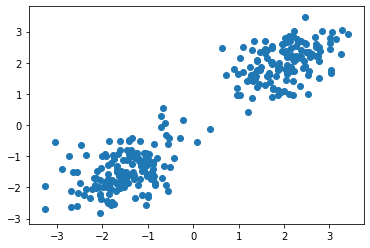

In [7]:
# Prepare x_train
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

indices = np.random.randint(2, size=300)
samples = [np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

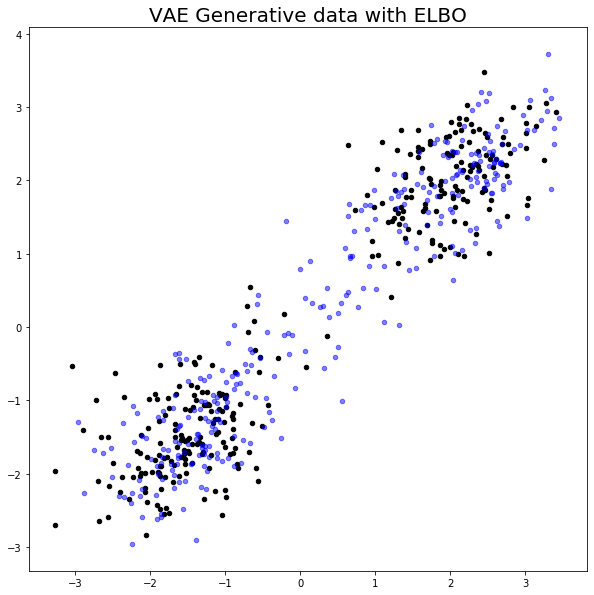

In [8]:
elbo_vae_instance = train_ELBO_VAE_batched(x_train)
visualize_VAE(elbo_vae_instance, x_train, "ELBO")

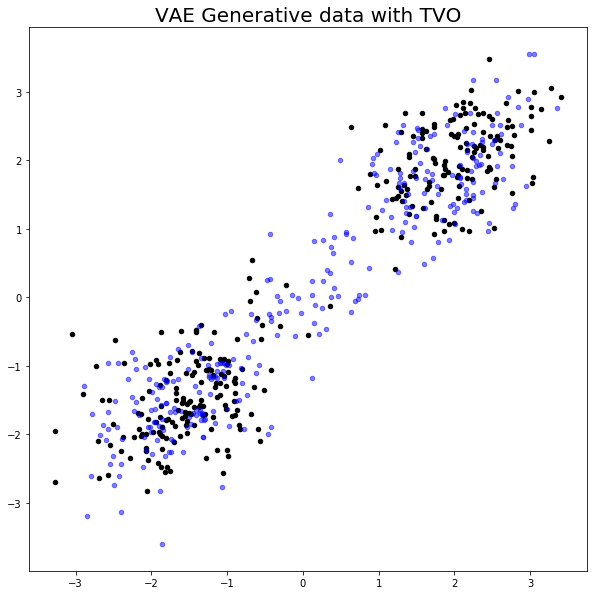

In [9]:
tvo_vae_instance = train_TVO_VAE_batched(x_train)
visualize_VAE(elbo_vae_instance, x_train, "TVO")

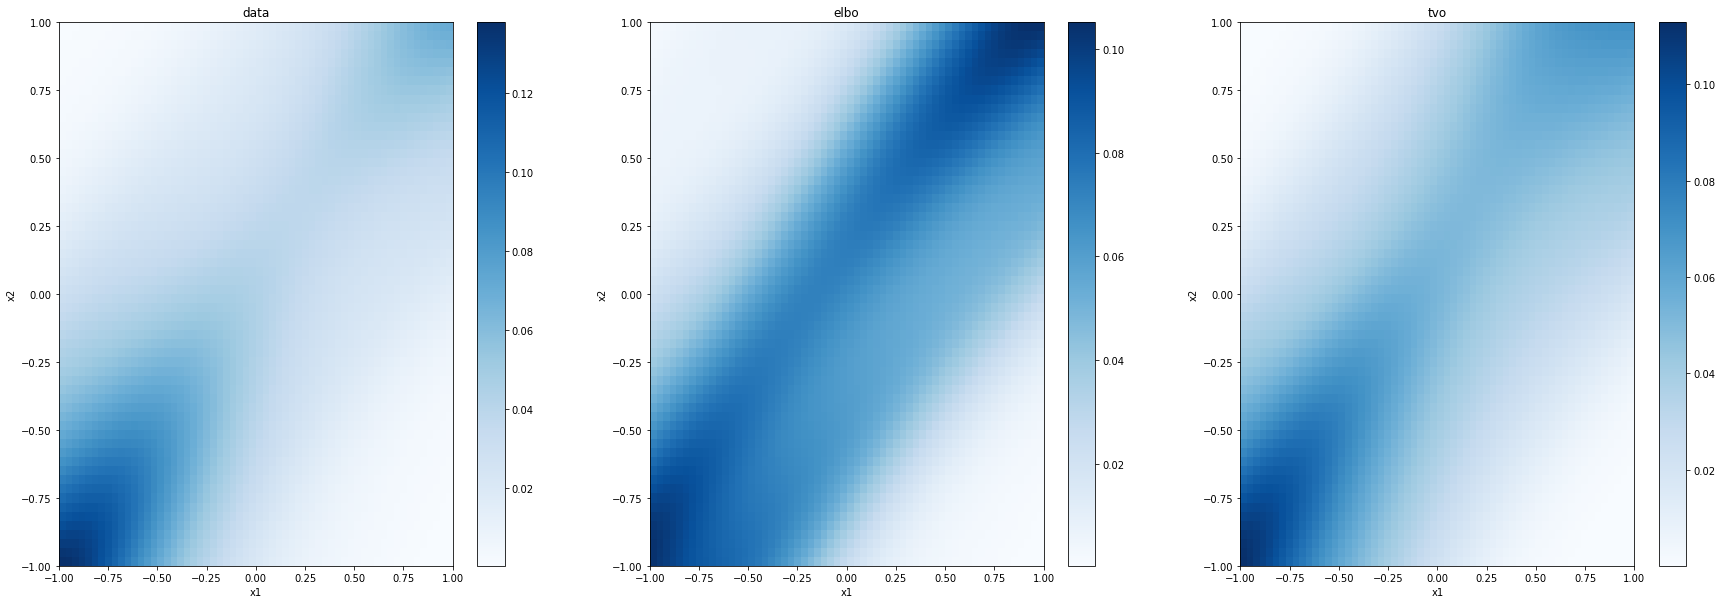

In [10]:
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train)

## Test Case 2

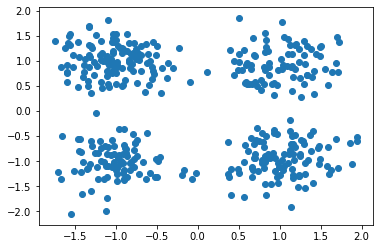

In [11]:
# Prepare x_train
c_means = [[-1.0, -1.0], [1.0, 1.0], [1.0, -1.0], [-1.0, 1.0]]
c_var = 0.05**2
x_var = 1e-2

indices = np.random.randint(4, size=400)
samples = [np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.01 * np.ones((2, 2))) + np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

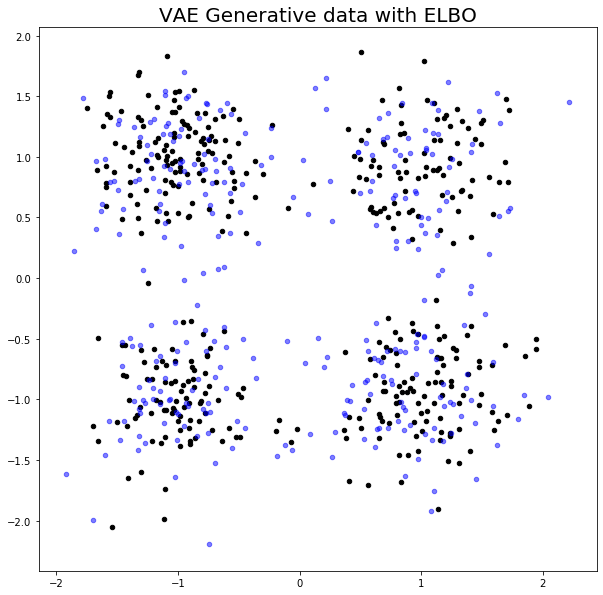

In [12]:
elbo_vae_instance = train_ELBO_VAE_batched(x_train)
visualize_VAE(elbo_vae_instance, x_train, "ELBO")

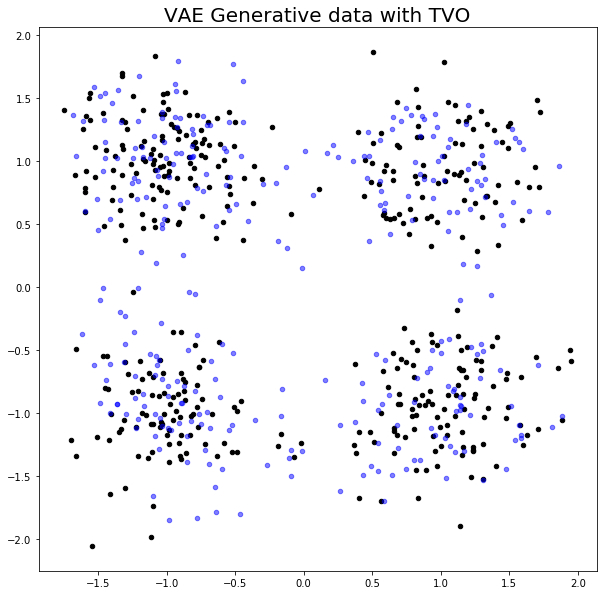

In [13]:
tvo_vae_instance = train_TVO_VAE_batched(x_train)
visualize_VAE(elbo_vae_instance, x_train, "TVO")

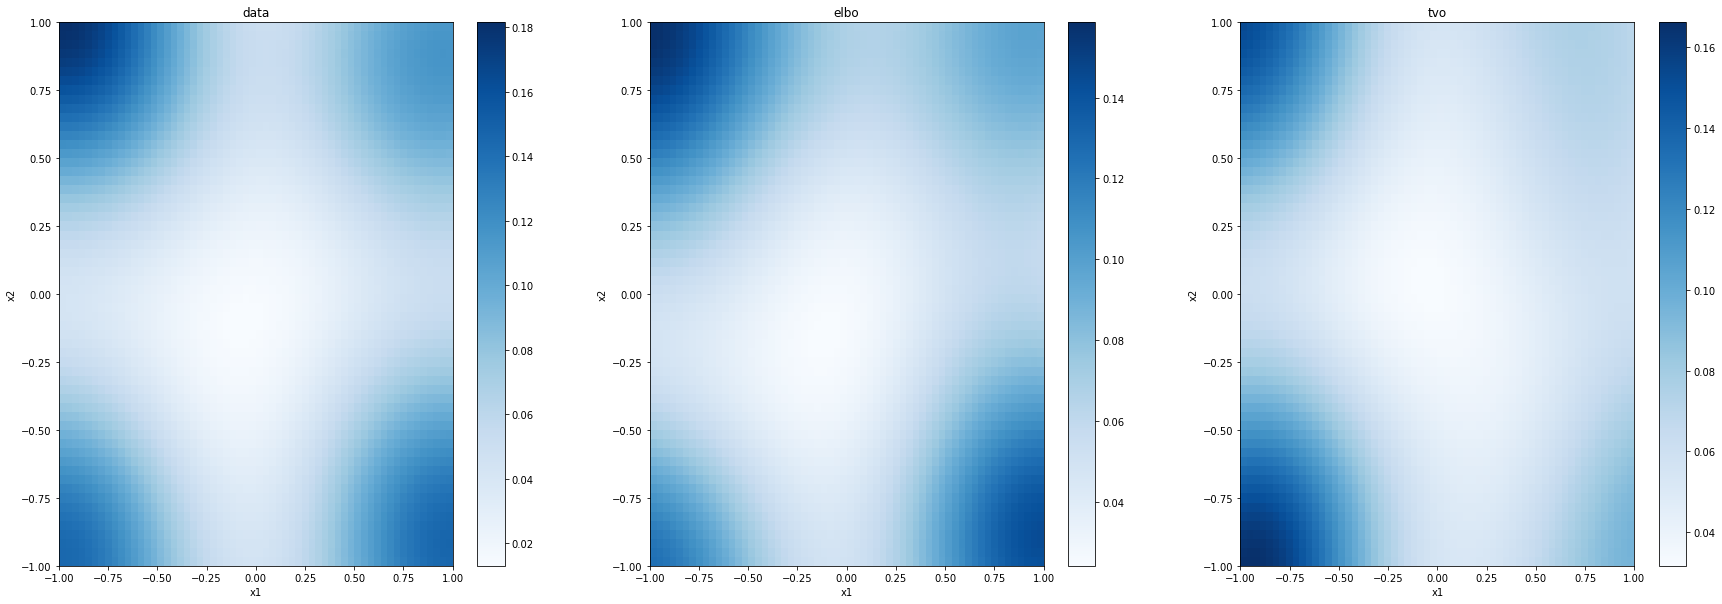

In [14]:
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train)

## Experiment 1: Cross Curve Data

$$
\begin{aligned}z & \sim \mathcal{N}(0,1) \\\epsilon & \sim \mathcal{N}\left(0, \sigma_{\epsilon}^{2} \cdot I\right) \\u(z) &=(0.6+1.8 \cdot \Phi(z)) \pi \\ 
x \mid z&=\underbrace{\left[\begin{array}{c}
\frac{\sqrt{2}}{2} \cdot \frac{\cos (u(z))}{\sin (u(z))^{2}+1} \\
\sqrt{2} \cdot \frac{\cos (u(z)) \sin (u(z))}{\sin (u(z))^{2}+1}
\end{array}\right]}_{f_{\theta_{\mathrm{GT}}}(z)}+\epsilon\end{aligned}
$$

here $\Phi(z)$ is the Gaussian $\mathrm{CDF}$ and $\sigma_{\epsilon}^{2}=0.02$

In [15]:
x_var=0.02
dpath="C:\\Users\\pc\\am207-tvo-project\\data\\CrossCurves_x.npy"
x_train=np.load(dpath).T
print(x_train.shape)

(10000, 2)


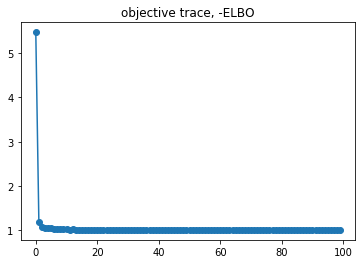

In [16]:
elbo_vae_instance = random_start_ELBO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=2, n_epochs=50, batch_size=100)
plt.plot(elbo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -ELBO')
plt.show()

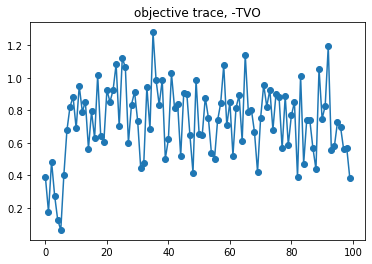

In [17]:
tvo_vae_instance = random_start_TVO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=2, n_epochs=50, batch_size=100)
plt.plot(tvo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -TVO')
plt.show()

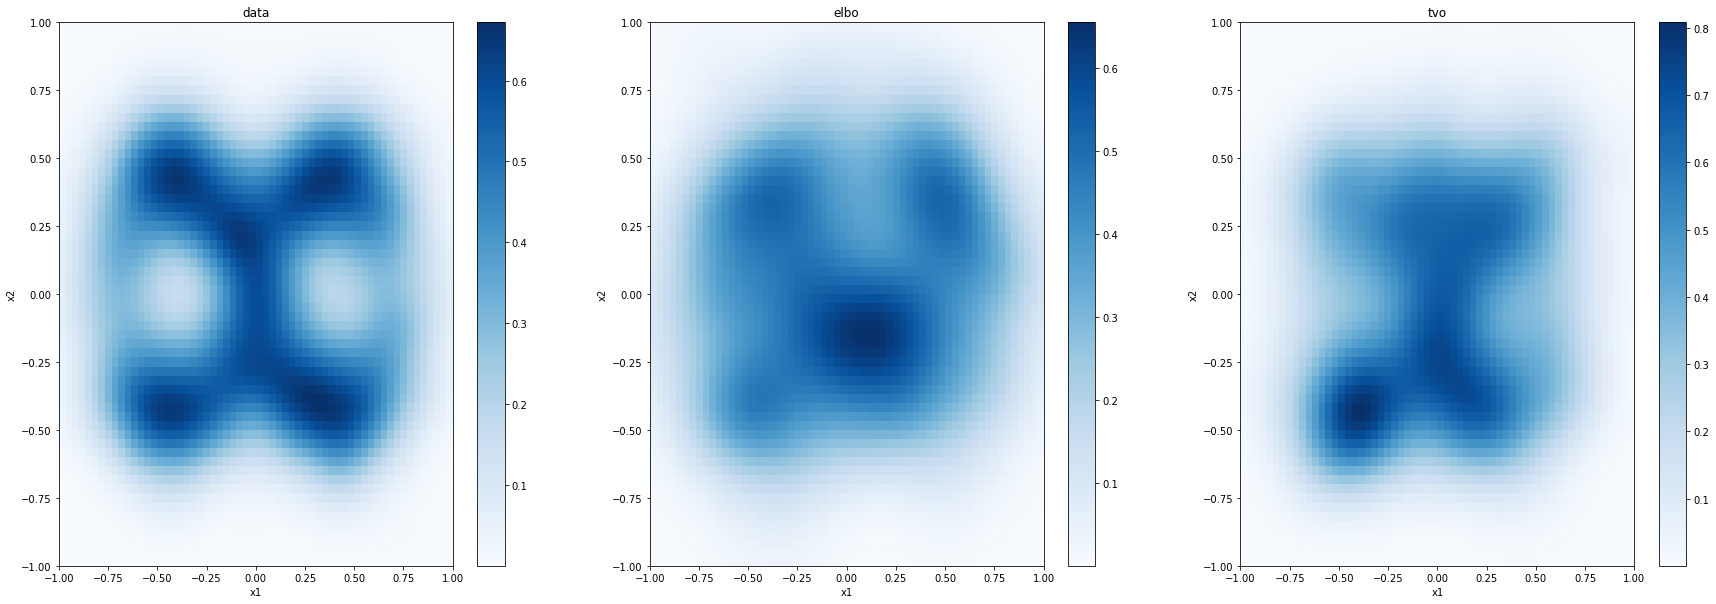

In [18]:
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train, x_var=x_var)

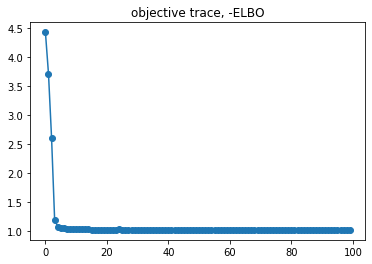

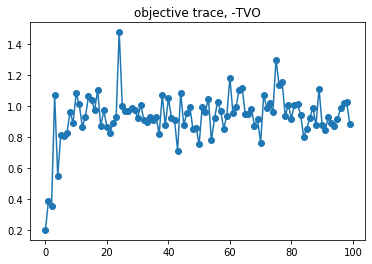

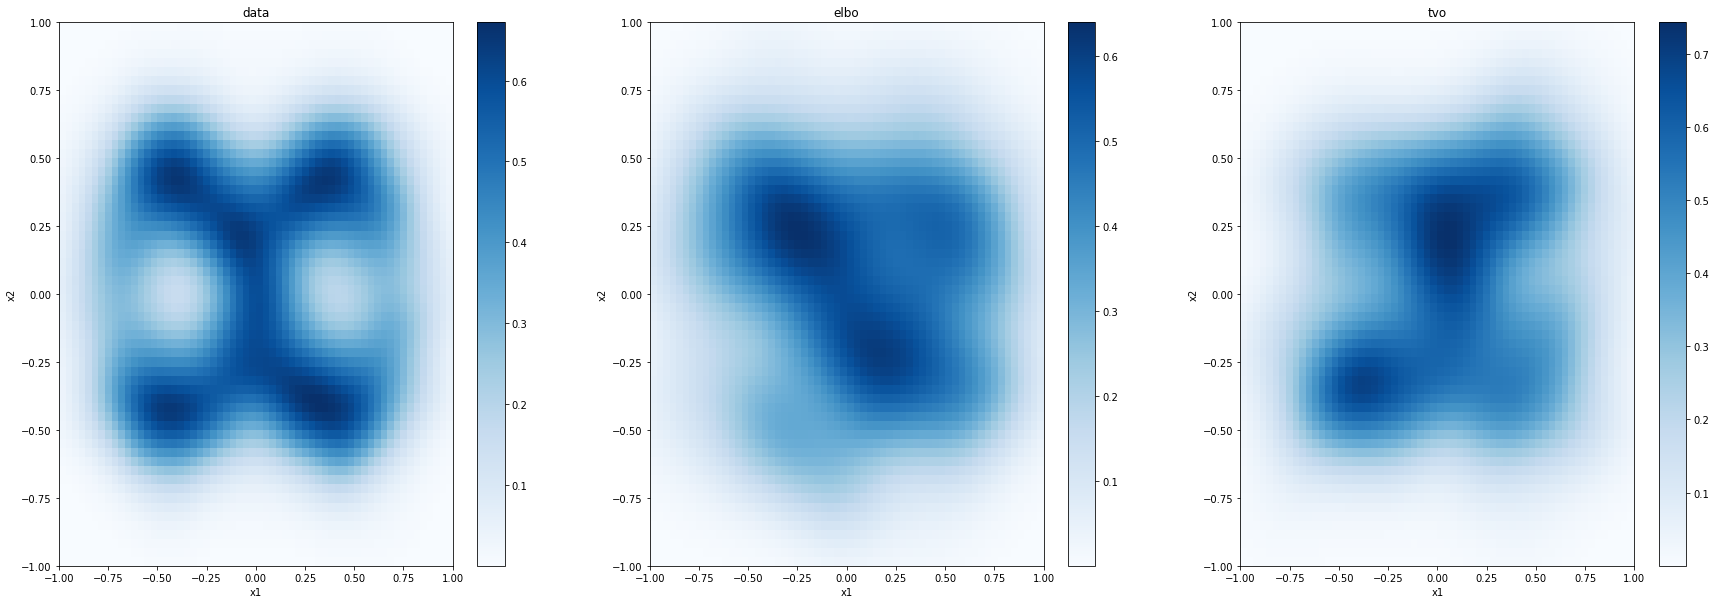

In [19]:
#gradient descent
elbo_vae_instance = random_start_ELBO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=4, n_epochs=5000, batch_size=x_train.shape[0])
tvo_vae_instance = random_start_TVO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=4, n_epochs=5000, batch_size=x_train.shape[0])
plt.plot(elbo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -ELBO')
plt.show()
plt.plot(tvo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -TVO')
plt.show()
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train, x_var=x_var)

In [20]:
# #NAS
# z_dim_list = [5,10,20,40]
# width_list = [20,40,80]
# hidden_layers_list = [2,4,8]
# learning_rate_list = [0.1, 0.01, 0.0001]
# S_list = [10,20,40]
# batch_size_list = [64,256,1024]
# elbo_instance = NAS_ELBO_VAE(x_train, 
#                   z_dim_list,
#                   width_list,
#                   hidden_layers_list, 
#                   learning_rate_list,
#                   S_list, 
#                   batch_size_list,
#                   x_var = x_var)
# tvo_instance = NAS_TVO_VAE(x_train, 
#                   z_dim_list,
#                   width_list,
#                   hidden_layers_list, 
#                   learning_rate_list,
#                   S_list, 
#                   batch_size_list,
#                   x_var = x_var)
# plt.plot(elbo_vae_instance.objective_trace, 'o-')
# plt.title('objective trace, -ELBO')
# plt.show()
# plt.plot(tvo_vae_instance.objective_trace, 'o-')
# plt.title('objective trace, -TVO')
# plt.show()
# compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train, x_var=x_var)

## Experiment 2: Three clusters data
$$
\begin{aligned}z & \sim \mathcal{N}(0,1) \\\epsilon & \sim \mathcal{N}\left(0, \sigma_{\epsilon}^{2} \cdot I\right) \\u(z) &=\frac{2 \pi}{1+e^{-\frac{1}{2} \pi z}} \\ t(u)&=2 \cdot \tanh (10 \cdot u-20 \cdot\lfloor u / 2\rfloor-10)+4 \cdot\lfloor u / 2\rfloor+2 \\ x \mid z&=\underbrace{\left[\begin{array}{c}
\cos (t(u(z))) \\
\sin (t(u(z)))
\end{array}\right]}_{f_{\theta_{\mathrm{GT}}}(z)}+\epsilon\end{aligned}
$$

${\sigma}_{\epsilon}^{2}=0.2$

In [21]:
x_var=0.02
dpath="C:\\Users\\pc\\am207-tvo-project\\data\\ThreeClusters_x.npy"
x_train=np.load(dpath).T
print(x_train.shape)

(10000, 2)


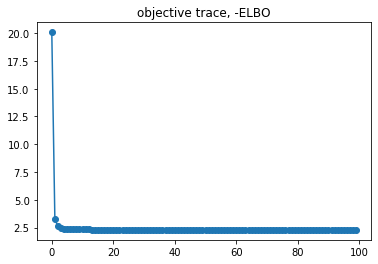

In [22]:
elbo_vae_instance = random_start_ELBO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=3, n_epochs=50, batch_size=100)
plt.plot(elbo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -ELBO')
plt.show()

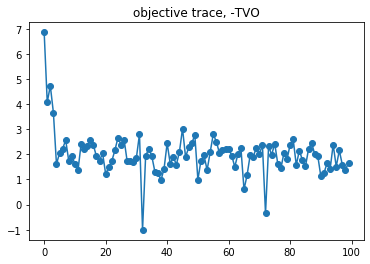

In [23]:
tvo_vae_instance = random_start_TVO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=3, n_epochs=50, batch_size=100)
plt.plot(tvo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -TVO')
plt.show()

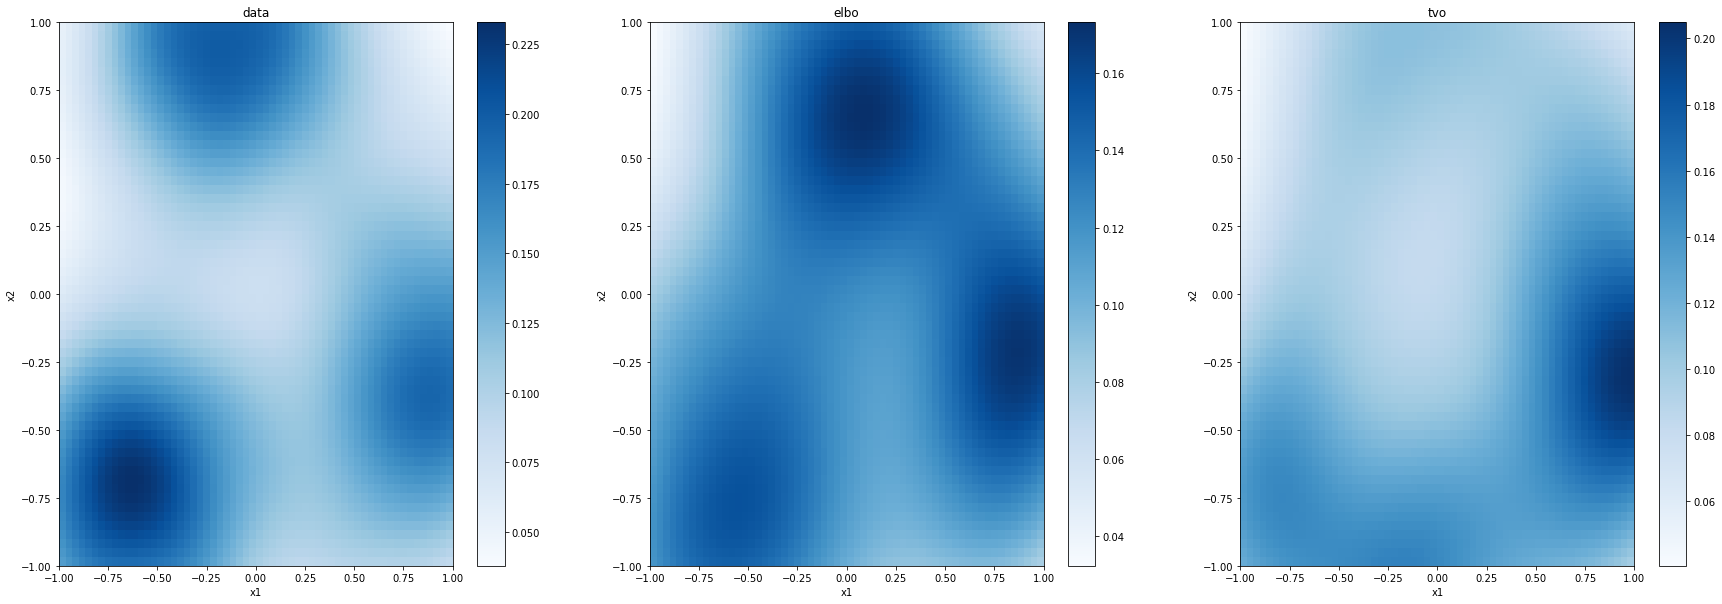

In [24]:
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train, x_var=x_var)

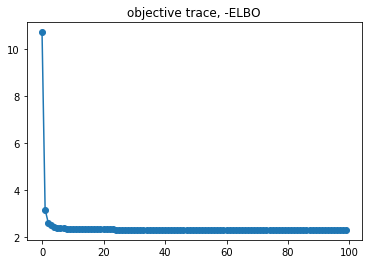

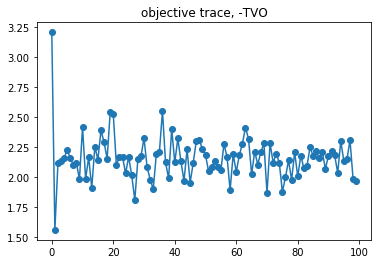

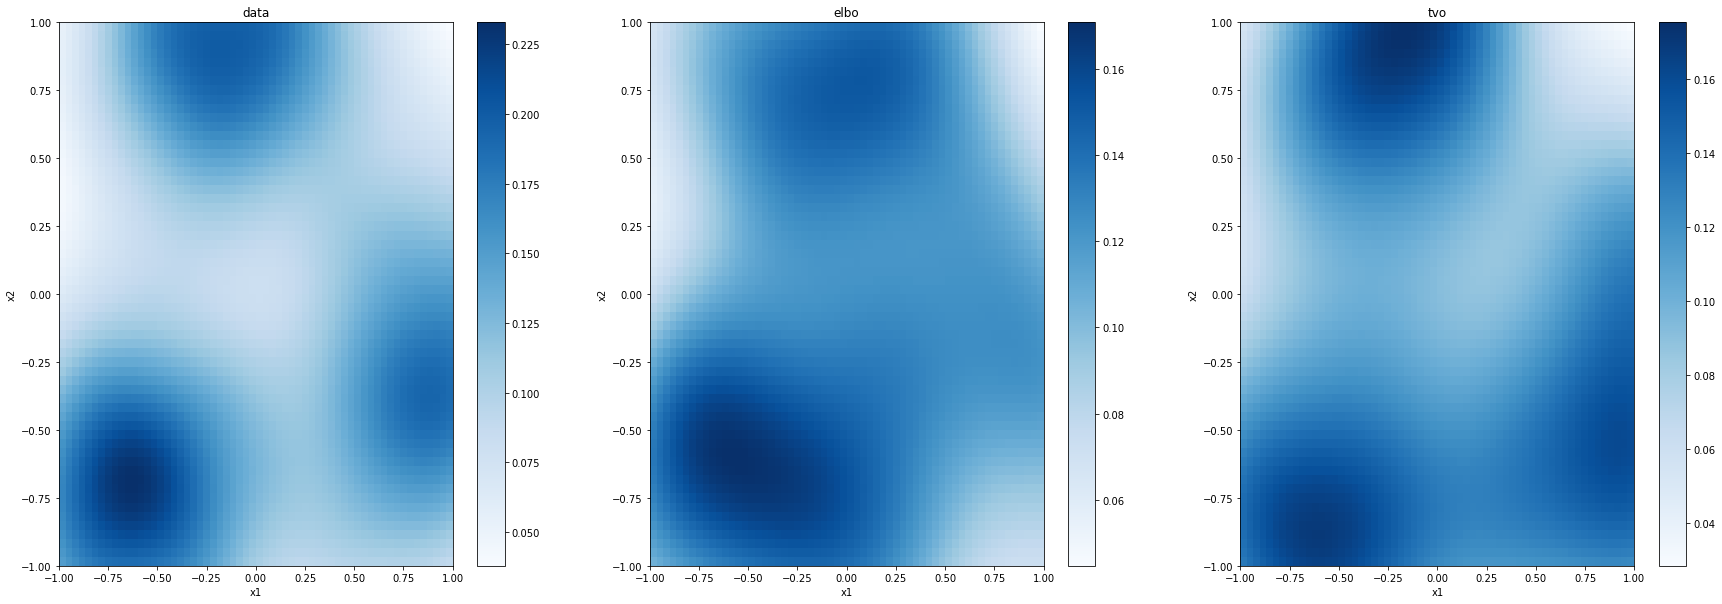

In [25]:
#gradient descent
elbo_vae_instance = random_start_ELBO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=3, n_epochs=5000, batch_size=x_train.shape[0])
tvo_vae_instance = random_start_TVO_VAE(x_train, x_var = x_var, hidden_layers = 3, learning_rate = 1e-3, z_dim=3, n_epochs=5000, batch_size=x_train.shape[0])
plt.plot(elbo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -ELBO')
plt.show()
plt.plot(tvo_vae_instance.objective_trace, 'o-')
plt.title('objective trace, -TVO')
plt.show()
compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train, x_var=x_var)

In [26]:
# #NAS
# z_dim_list = [5,10,20,40]
# width_list = [20,40,80]
# hidden_layers_list = [2,4,8]
# learning_rate_list = [0.1, 0.01, 0.0001]
# S_list = [10,20,40]
# batch_size_list = [64,256,1024]
# elbo_instance = NAS_ELBO_VAE(x_train, 
#                   z_dim_list,
#                   width_list,
#                   hidden_layers_list, 
#                   learning_rate_list,
#                   S_list, 
#                   batch_size_list,
#                   x_var = x_var)
# tvo_instance = NAS_TVO_VAE(x_train, 
#                   z_dim_list,
#                   width_list,
#                   hidden_layers_list, 
#                   learning_rate_list,
#                   S_list, 
#                   batch_size_list,
#                   x_var = x_var)
# plt.plot(elbo_vae_instance.objective_trace, 'o-')
# plt.title('objective trace, -ELBO')
# plt.show()
# plt.plot(tvo_vae_instance.objective_trace, 'o-')
# plt.title('objective trace, -TVO')
# plt.show()
# compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train, x_var=x_var)